2. In this question you will implement and compare the following different KNN variants (see: https://youtu.be/C9HQLyXwEw0?t=3382)

 LSH (1 marks)

 KD-tree (1 marks)

 Naive version of KNN (0.5 marks)

 Vary dataset size $N$, number of dimensions $D$ to do training and testing time and memory comparison for finding $K$ nearest neighbours. (1 mark)

 Now, in a 2d randomly generated dataset visually show how many of the $K$ closest neighbors appx. $K$ NN methods miss out due to their approximate nature.

 Also show the partitions in the 2d space. (0.5 marks)



In [1]:
import numpy as np
import time
import psutil
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from scipy.spatial import KDTree
import sys
import tracemalloc

In [2]:
random_seed = 42
np.random.seed(random_seed)

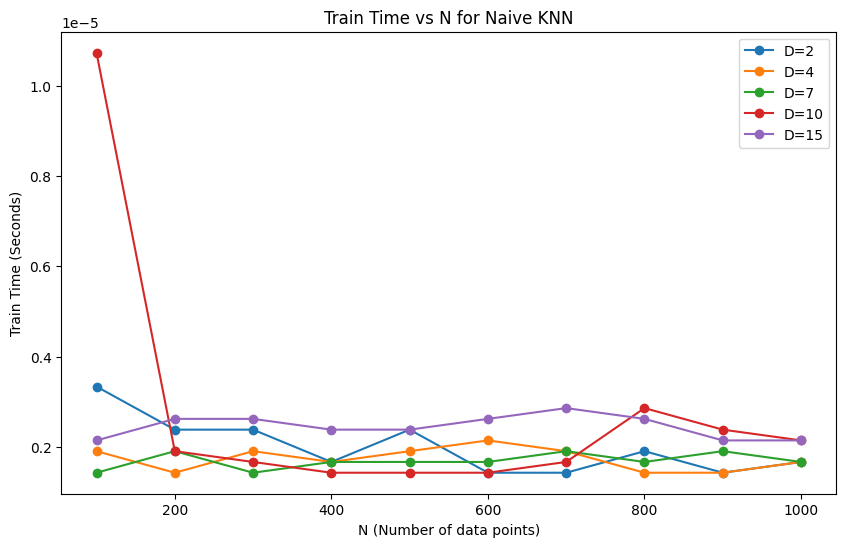

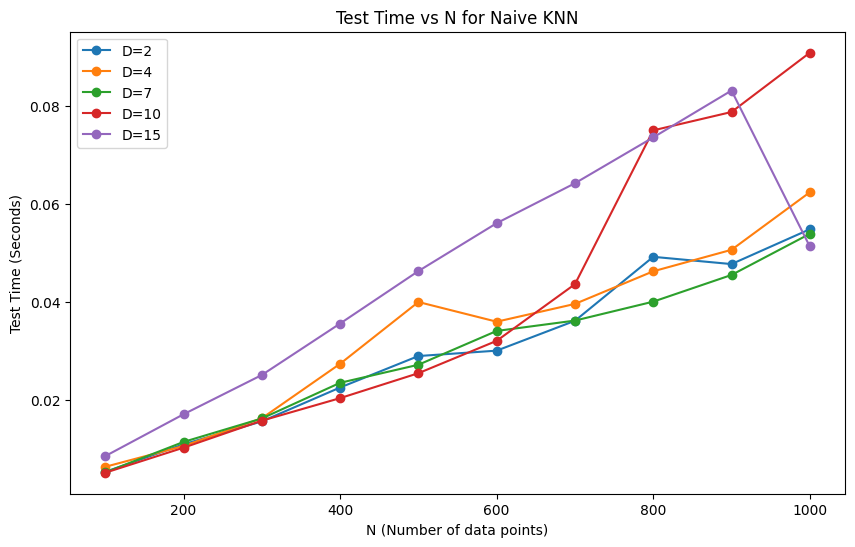

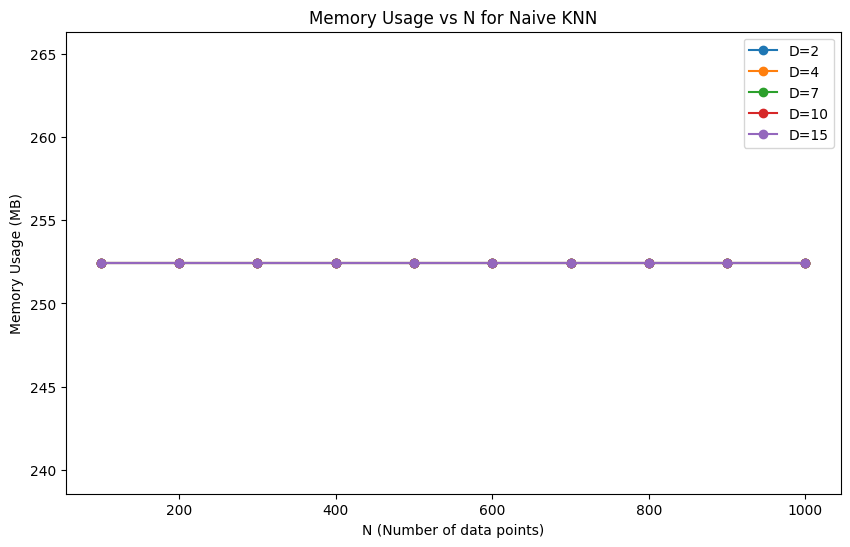

In [ ]:
# NaiveKNN Class
class NaiveKNN:
    def __init__(self, k):
        self.k = k
        self.data = None

    def fit(self, data):
        self.data = data  # Storing the training data

    def predict(self, query):
        distances = [distance.euclidean(query, point) for point in self.data]
        neighbors = np.argsort(distances)[:self.k]
        return neighbors

# Function to measure performance metrics
def measure_performance(model, data, queries, k, num_runs=5):
    # Measure training time
    start = time.time()
    model.fit(data)
    train_time = time.time() - start

    # Measure testing time
    test_times = []
    for _ in range(num_runs):
        start = time.time()
        for query in queries:
            model.predict(query)
        test_times.append(time.time() - start)

    avg_test_time = np.mean(test_times)

    # Measure memory usage
    memory_usage = psutil.Process().memory_info().rss  # in bytes

    return train_time, avg_test_time, memory_usage

# Experiment Setup
N_values = np.arange(100,1001,100)  # Example values for N (number of points)
D_values = [2, 4, 7, 10, 15]        # Example values for D (dimensions)
k = 5                         # Number of neighbors to find
results = {D: {'Train Time': [], 'Test Time': [], 'Memory Usage': []} for D in D_values}

# Loop through different N and D values
for D in D_values:
    for N in N_values:
        # Generate clustered data
        X_pattern, y_pattern = make_blobs(n_samples=N, centers=3, n_features=D, cluster_std=2, random_state=0)

        # Split into train/test sets (80% train, 20% test)
        X_train_pattern, X_test_pattern, _, _ = train_test_split(X_pattern, y_pattern, test_size=0.2, random_state=1234)

        model = NaiveKNN(k=k)
        train_time, test_time, memory_usage = measure_performance(model, X_train_pattern, X_test_pattern[:10], k)

        # Store the results
        results[D]['Train Time'].append(train_time)
        results[D]['Test Time'].append(test_time)
        results[D]['Memory Usage'].append(memory_usage)

# Plotting Results
def plot_performance_graph(N_values, results, metric_name):
    plt.figure(figsize=(10, 6))
    for D, metrics in results.items():
        if metric_name == 'Memory Usage':
            # Convert memory usage to MB from bytes
            plt.plot(N_values, np.array(metrics[metric_name]) / (1024 * 1024), marker='o', label=f'D={D}')
            plt.ylabel(f"{metric_name} (MB)")  # Add unit to label
        else:
            plt.plot(N_values, metrics[metric_name], marker='o', label=f'D={D}')
            plt.ylabel(f"{metric_name} (Seconds)")

    plt.title(f"{metric_name} vs N for Naive KNN")
    plt.xlabel("N (Number of data points)")
    plt.legend()
    plt.show()

# Plot each performance metric
plot_performance_graph(N_values, results, 'Train Time')
plot_performance_graph(N_values, results, 'Test Time')
plot_performance_graph(N_values, results, 'Memory Usage')

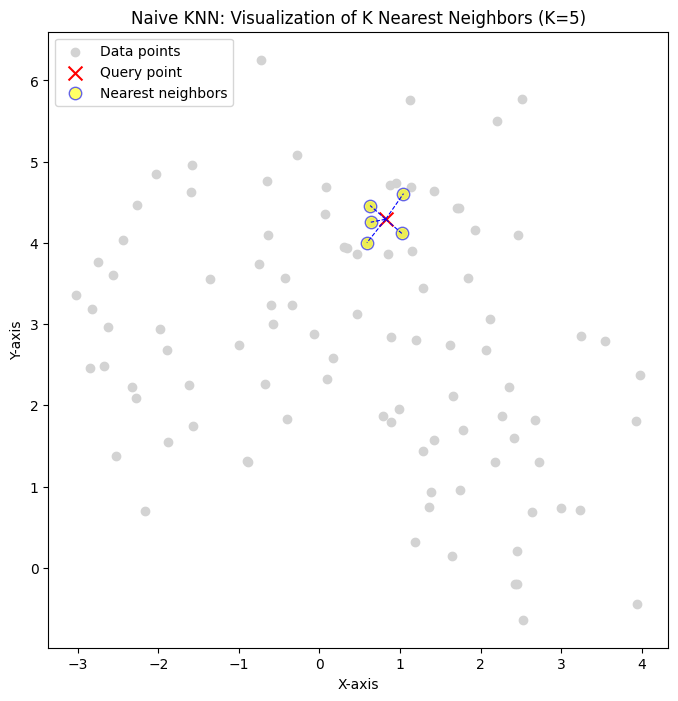

In [ ]:
# Generate a clustered 2D dataset using make_blobs
np.random.seed(0)
data_2d, _ = make_blobs(n_samples=100, centers=3, n_features=2, cluster_std=1.0, random_state=0)

# Generate a random query point (within the data range for better visualization)
query_point = np.random.rand(1, 2)[0] * (data_2d.max(axis=0) - data_2d.min(axis=0)) + data_2d.min(axis=0)
k = 5  # Number of neighbors

# Initialize and fit the NaiveKNN model
naive_knn = NaiveKNN(k=k)
naive_knn.fit(data_2d)

# Get the K nearest neighbors for the query point
neighbors_indices = naive_knn.predict(query_point)
neighbors = data_2d[neighbors_indices]

# Plot the dataset and neighbors
plt.figure(figsize=(8, 8))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c='lightgray', label="Data points")
plt.scatter(query_point[0], query_point[1], color="red", label="Query point", marker="x", s=100)
plt.scatter(neighbors[:, 0], neighbors[:, 1], edgecolor='blue', color="yellow", label="Nearest neighbors", s=80, alpha=0.6)

# Draw lines from the query point to its neighbors
for neighbor in neighbors:
    plt.plot([query_point[0], neighbor[0]], [query_point[1], neighbor[1]], 'b--', linewidth=0.8)

plt.legend()
plt.title("Naive KNN: Visualization of K Nearest Neighbors (K=5)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

##Locality-Sensitive Hashing (LSH)

In [9]:
class LSH:
    def __init__(self, k, num_hashes=20):
        self.k = k  # Number of neighbors to return
        self.num_hashes = num_hashes  # Number of hash functions=random hyperplane
        self.buckets = {}
        self.projections = []

    def fit(self, data):
        self.data = data
        n, d = data.shape
        # Generate random hyperplanes (hash functions)
        self.projections = [np.random.randn(d) for _ in range(self.num_hashes)]

        # Hash the data points and store them in buckets
        for idx, point in enumerate(data):
            hash_value = self.hash_point(point)
            if hash_value not in self.buckets:
                self.buckets[hash_value] = []
            self.buckets[hash_value].append(idx)

    def hash_point(self, point):
        # Generate a hash based on sign of dot product with projections
        return ''.join(['1' if np.dot(point, p) > 0 else '0' for p in self.projections])

    def predict(self, query_point):
        # Retrieve candidates from the hash bucket
        hash_value = self.hash_point(query_point)
        candidates = self.buckets.get(hash_value, [])

        # Filter the candidates by Euclidean distance to keep only closest K
        if not candidates:
            candidates = self.search_similar_buckets(hash_value)

        # If still no candidates, fall back to brute force
        if not candidates:
            return self.get_neighbors(query_point)

        # Filter candidates by Euclidean distance to keep only closest K
        candidate_points = self.data[candidates]
        distances = euclidean_distances([query_point], candidate_points).flatten()
        closest_indices = np.argsort(distances)[:self.k]
        return np.array(candidates)[closest_indices]

    def search_similar_buckets(self, hash_value):
        # Generate neighboring bucket keys by flipping bits
        neighbors = []
        for i in range(len(hash_value)):
            flipped_hash = list(hash_value)
            flipped_hash[i] = '0' if hash_value[i] == '1' else '1'
            flipped_hash = ''.join(flipped_hash)
            neighbors.extend(self.buckets.get(flipped_hash, []))
        return neighbors

    def get_neighbors(self, query_point):
        # Find true K nearest neighbors based on exact Euclidean distance
        distances = euclidean_distances([query_point], self.data).flatten()
        true_neighbors = np.argsort(distances)[:self.k]
        return true_neighbors

In [10]:
def measure_performance_LSH(model, data, queries, k, num_runs=15):
    # Measure training time
    start = time.time()
    model.fit(data)
    train_time = time.time() - start

    # Measure testing time averaged over multiple runs
    test_times = []
    for _ in range(num_runs):
        start = time.time()
        for query in queries:
            model.predict(query)
        test_times.append(time.time() - start)

    avg_test_time = np.mean(test_times)  # Average testing time over multiple runs
    # memory_usage = psutil.Process().memory_info().rss  # Memory usage in bytes
    bucket_memory = sum(sys.getsizeof(bucket) for bucket in model.buckets.values())
    projection_memory = sum(sys.getsizeof(projection) for projection in model.projections)

    memory_usage = bucket_memory + projection_memory  # Total memory usage

    return train_time, avg_test_time, memory_usage

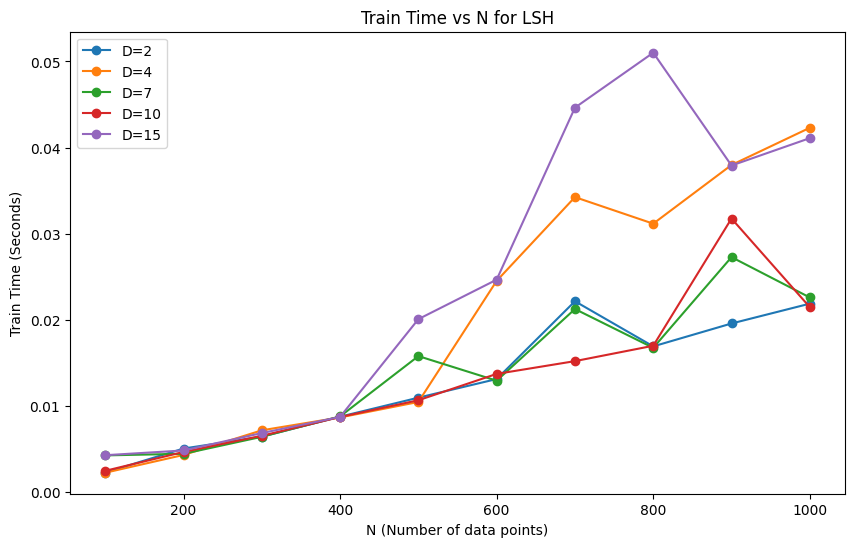

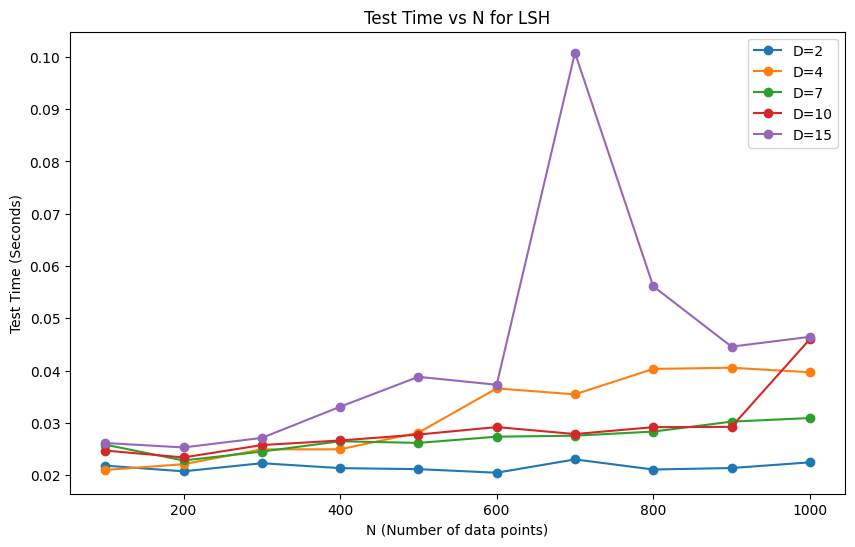

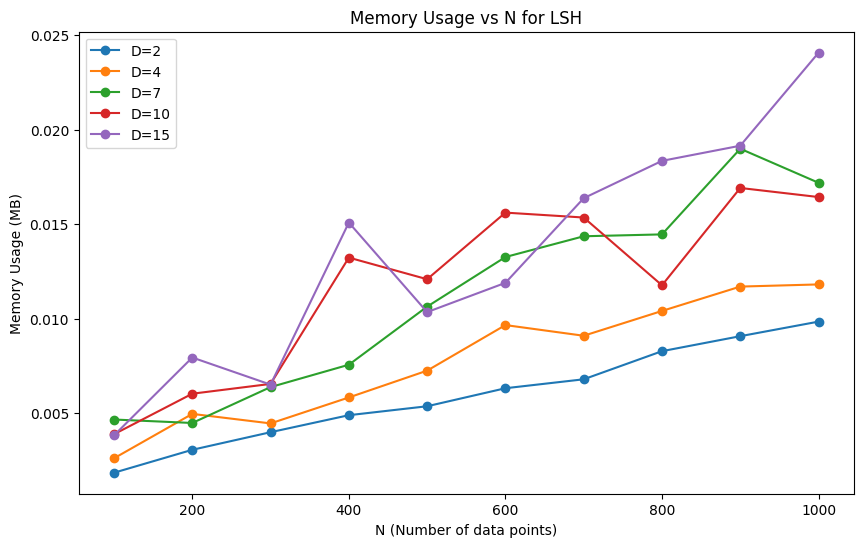

In [ ]:
import matplotlib.pyplot as plt

def plot_performance_graph(N_values, results, metric_name):
    plt.figure(figsize=(10, 6))
    for D, metrics in results.items():
        if metric_name == 'Memory Usage':
            # Convert memory usage to MB from bytes
            plt.plot(N_values, np.array(metrics[metric_name]) / (1024 * 1024), marker='o', label=f'D={D}')
            plt.ylabel(f"{metric_name} (MB)")  # Add unit to label
        else:
            plt.plot(N_values, metrics[metric_name], marker='o', label=f'D={D}')
            plt.ylabel(f"{metric_name} (Seconds)")

    plt.title(f"{metric_name} vs N for LSH")
    plt.xlabel("N (Number of data points)")
    plt.legend()
    plt.show()

# Example use case
N_values = np.arange(100,1001,100)  # Example values for N (number of points)
D_values = [2, 4, 7, 10, 15]        # Example values for D (dimensions)
results = {D: {'Train Time': [], 'Test Time': [], 'Memory Usage': []} for D in D_values}

for D in D_values:
    for N in N_values:
        data,_ = make_blobs(n_samples=N, centers=3, n_features=D, cluster_std=1.5, random_state=random_seed)
        queries = np.random.rand(50, D)    # 10 random queries for testing

        model = LSH(k=5)
        train_time, test_time, memory_usage = measure_performance_LSH(model, data, queries, k=5)

        results[D]['Train Time'].append(train_time)
        results[D]['Test Time'].append(test_time)
        results[D]['Memory Usage'].append(memory_usage)

# Plot each performance metric
plot_performance_graph(N_values, results, 'Train Time')
plot_performance_graph(N_values, results, 'Test Time')
plot_performance_graph(N_values, results, 'Memory Usage')

## Varying N:
1. **Training Time vs  N:** The training time seems to increase as  N increases. This is expected as more data points require more hashes to be computed and more entries to be stored in the hash table.

2. **Query Time vs  N:** The query time fluctuates but generally shows a trend of increasing with  N. The slight variability might be due to the randomness in the data generation and hashing, affecting which bucket the query point falls into.

3. **Memory Usage vs  N:** Memory usage increases with   N. This is straightforward since the hash table stores more indices as N increases.

## Varying D:

1. **Training Time vs D:** Increases as D increases because hashing points and generating hyperplanes both scale with D.
2. **Testing Time vs D:** Increases as D increases because hashing query points and computing distances to candidates depend linearly on D.
3. **Memory Usage:** Increases as num_hashes*D hyperplanes we stores.

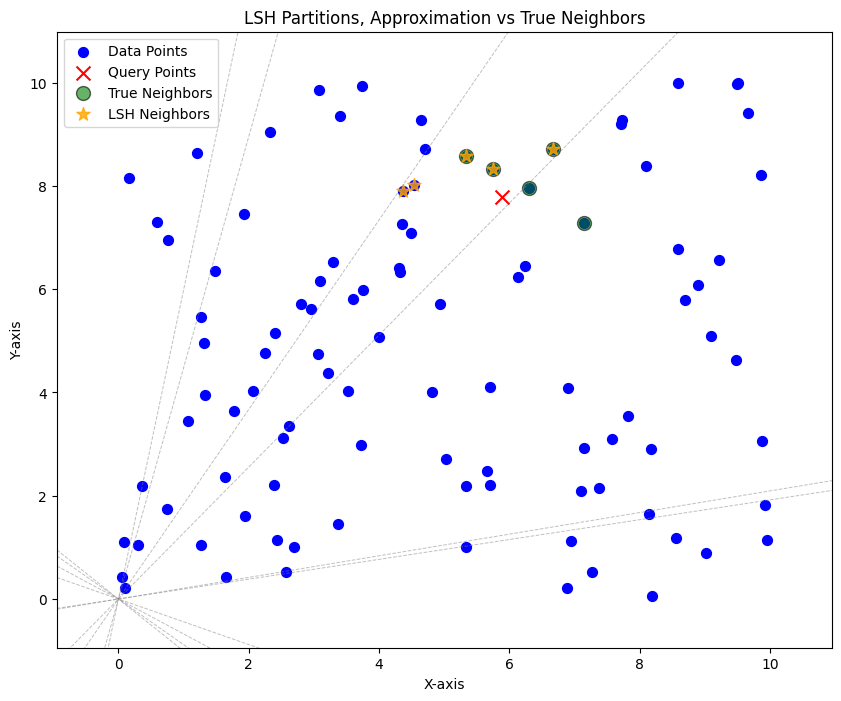

In [12]:
def visualize_LSH_2d(data, queries, model):
    plt.figure(figsize=(10, 8))

    # Plot data points
    plt.scatter(data[:, 0], data[:, 1], c='blue', label='Data Points', s=50)

    # Plot query points
    plt.scatter(queries[:, 0], queries[:, 1], c='red', label='Query Points', s=100, marker='x')

    # Initialize flags to prevent duplicate legend entries
    true_neighbors_plotted = False
    approx_neighbors_plotted = False

    # Visualize true neighbors and LSH neighbors for each query
    for query in queries:
        # Find true nearest neighbors using exact distance
        true_neighbors = np.argsort(euclidean_distances([query], data).flatten())[:model.k]
        true_data_points = data[true_neighbors]
        plt.scatter(true_data_points[:, 0], true_data_points[:, 1],
                    c='green', s=100, edgecolor='black', alpha=0.6,
                    label='True Neighbors' if not true_neighbors_plotted else None)
        true_neighbors_plotted = True

        # Get LSH approximate neighbors
        approx_neighbors = model.predict(query)
        approx_data_points = data[approx_neighbors]
        plt.scatter(approx_data_points[:, 0], approx_data_points[:, 1],
                    c='orange', s=100, marker='*', alpha=0.8,
                    label='LSH Neighbors' if not approx_neighbors_plotted else None)
        approx_neighbors_plotted = True

    # Plot hyperplanes (partitions)
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    for i, p in enumerate(model.projections):
        # Assuming data is 2D
        if data.shape[1] == 2:
            x_vals = np.linspace(x_min, x_max, 200)
            y_vals = -(p[0] / p[1]) * x_vals  # Equation for a hyperplane in 2D
            plt.plot(x_vals, y_vals, '--', color='gray', linewidth=0.7, alpha=0.5)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc='upper left', fontsize=10)
    plt.title("LSH Partitions, Approximation vs True Neighbors")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    # plt.grid(True, alpha=0.3)
    plt.show()

# Example usage
N = 100
D = 2
data = np.random.rand(N, D) * 10  # Scale to a larger range for better visualization
queries = np.random.rand(1, D) * 10  # Scale query points similarly

model = LSH(k=5, num_hashes=10)
model.fit(data)
visualize_LSH_2d(data, queries, model)


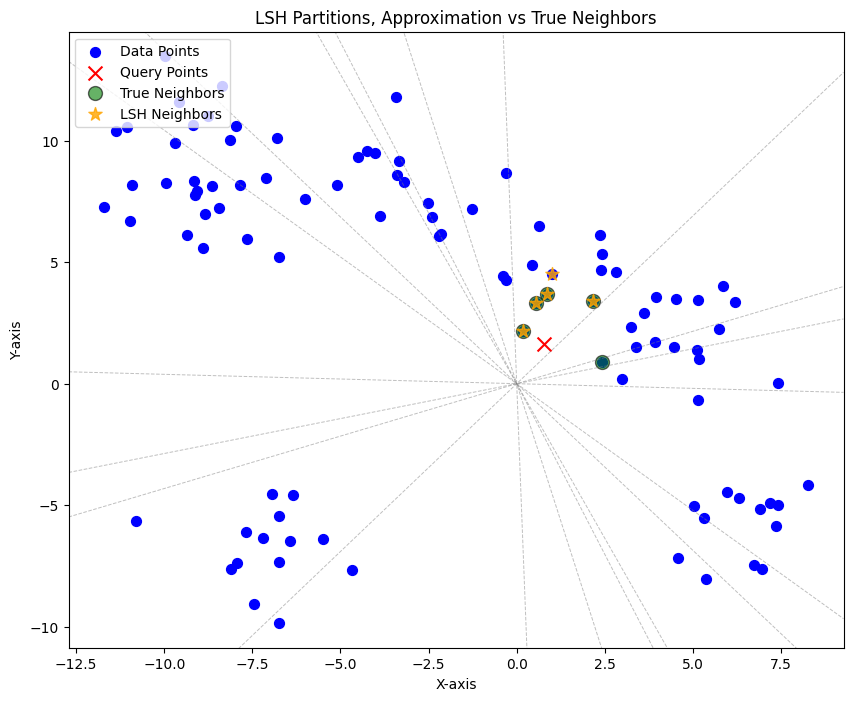

In [15]:
def visualize_LSH_2d(data, queries, model):
    plt.figure(figsize=(10, 8))

    # Plot data points
    plt.scatter(data[:, 0], data[:, 1], c='blue', label='Data Points', s=50)

    # Plot query points
    plt.scatter(queries[:, 0], queries[:, 1], c='red', label='Query Points', s=100, marker='x')

    # Initialize flags to prevent duplicate legend entries
    true_neighbors_plotted = False
    approx_neighbors_plotted = False

    # Visualize true neighbors and LSH neighbors for each query
    for query in queries:
        # Find true nearest neighbors using exact distance
        true_neighbors = np.argsort(euclidean_distances([query], data).flatten())[:model.k]
        true_data_points = data[true_neighbors]
        plt.scatter(true_data_points[:, 0], true_data_points[:, 1],
                    c='green', s=100, edgecolor='black', alpha=0.6,
                    label='True Neighbors' if not true_neighbors_plotted else None)
        true_neighbors_plotted = True

        # Get LSH approximate neighbors
        approx_neighbors = model.predict(query)
        approx_data_points = data[approx_neighbors]
        plt.scatter(approx_data_points[:, 0], approx_data_points[:, 1],
                    c='orange', s=100, marker='*', alpha=0.8,
                    label='LSH Neighbors' if not approx_neighbors_plotted else None)
        approx_neighbors_plotted = True

    # Plot hyperplanes (partitions)
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    for i, p in enumerate(model.projections):
        # Assuming data is 2D
        if data.shape[1] == 2:
            x_vals = np.linspace(x_min, x_max, 200)
            y_vals = -(p[0] / p[1]) * x_vals  # Equation for a hyperplane in 2D
            plt.plot(x_vals, y_vals, '--', color='gray', linewidth=0.7, alpha=0.5)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc='upper left', fontsize=10)
    plt.title("LSH Partitions, Approximation vs True Neighbors")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    # plt.grid(True, alpha=0.3)
    plt.show()

# Example usage
N = 100
D = 2
data, _ = make_blobs(n_samples=N, centers=7, n_features=D, cluster_std=1.5, random_state=42)  # Scale to a larger range for better visualization
queries = np.random.rand(1, D) * 10  # Scale query points similarly

model = LSH(k=5, num_hashes=10)
model.fit(data)
visualize_LSH_2d(data, queries, model)


> The randomness in LSH works because it leverages the geometry of the data: points that are similar (closely aligned) are statistically more likely to produce similar hash values when projected onto random hyperplanes. While the planes are not "learned," their probabilistic behavior ensures that similar points often share the same bucket by chance, which is sufficient for approximate nearest neighbor searches.

##KD-Tree(K Dimentional tree)

In [3]:
class KDTreeNode:
    def __init__(self, point, left=None, right=None, axis=0, is_leaf=False):
        self.point = point
        self.left = left
        self.right = right
        self.axis = axis
        self.is_leaf = is_leaf

class KDTree:
    def __init__(self, data, max_leaf_size=5, max_depth=None):
        self.splits = []  # Storing splits for the entire tree construction
        self.max_depth = max_depth
        self.max_leaf_size = max_leaf_size  # Set max points in a leaf
        self.root = self.build_tree(data)

    def build_tree(self, data, depth=0):
        if len(data) <= self.max_leaf_size:
            # If leaf, stop splitting and mark as leaf
            return KDTreeNode(point=data, is_leaf=True)

        k = data.shape[1]
        axis = depth % k
        sorted_data = data[data[:, axis].argsort()]
        median_idx = len(sorted_data) // 2

        if self.max_depth is None or depth < self.max_depth:
            self.splits.append((axis, sorted_data[median_idx, axis], depth))

        left = self.build_tree(sorted_data[:median_idx], depth + 1)
        right = self.build_tree(sorted_data[median_idx + 1:], depth + 1)

        return KDTreeNode(
            point=sorted_data[median_idx],
            left=left,
            right=right,
            axis=axis
        )

    def approx_nearest_neighbor(self, query_point, k=1):
        best_neighbors = []
        self._approx_nearest(self.root, query_point, k, 0, best_neighbors)
        return [neighbor[1] for neighbor in sorted(best_neighbors, reverse=True)]

    def _approx_nearest(self, node, query_point, k, depth, best_neighbors):
        if node is None:
            return

        if node.is_leaf:
            # If it's a leaf node, consider all points in this leaf
            for point in node.point:
                dist = np.linalg.norm(point - query_point)
                if len(best_neighbors) < k:
                    best_neighbors.append((dist, point))
                elif dist < best_neighbors[0][0]:
                    best_neighbors[0] = (dist, point)
                    best_neighbors.sort(reverse=True)
            return

        axis = node.axis
        next_branch = node.left if query_point[axis] < node.point[axis] else node.right
        self._approx_nearest(next_branch, query_point, k, depth + 1, best_neighbors)

    def visualize_tree_with_leaf_boundaries(self, data, query_point, k):
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))

        # Plot for data points, true and approximate neighbors
        ax[0].scatter(data[:, 0], data[:, 1], c='blue', label='Data Points', s=50)
        ax[0].scatter(query_point[0], query_point[1], c='red', label='Query Point', s=100, marker='x')

        # Get approximate and actual neighbors
        approx_neighbors = self.approx_nearest_neighbor(query_point, k)
        actual_neighbors = self.get_actual_nearest_neighbors(data, query_point, k)

        # Plot actual neighbors with green circles
        for i, neighbor in enumerate(actual_neighbors):
            ax[0].scatter(neighbor[0], neighbor[1], c='green', s=100, marker='o', edgecolor='black', label='True Neighbors' if i == 0 else None)

        # Plot KD-Tree approximate neighbors with orange stars
        for i, neighbor in enumerate(approx_neighbors):
            ax[0].scatter(neighbor[0], neighbor[1], c='orange', s=100, marker='*', label='KD-Tree Neighbors' if i == 0 else None)

        # Ensure no duplicate labels in legend
        handles, labels = ax[0].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax[0].legend(by_label.values(), by_label.keys(), loc='best')
        ax[0].set_title("KD-Tree Approximation vs True Neighbors")

        # Plot leaf node boundaries
        self.plot_leaf_boundaries(ax[1], data, 0, 1, self.root, min(data[:, 0]), max(data[:, 0]), min(data[:, 1]), max(data[:, 1]))
        ax[1].scatter(data[:, 0], data[:, 1], c='blue', s=50)
        ax[1].set_title("KD-Tree Leaf Boundaries")

        plt.show()

    def plot_leaf_boundaries(self, ax, data, x_idx, y_idx, node, xmin, xmax, ymin, ymax):
        if node is None:
            return

        if node.is_leaf:
            # Draw the boundary box for the leaf node
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='gray', linestyle='--')
            ax.add_patch(rect)
            return

        axis = node.axis
        point = node.point

        if axis == x_idx:  # Vertical line
            self.plot_leaf_boundaries(ax, data, x_idx, y_idx, node.left, xmin, point[x_idx], ymin, ymax)
            self.plot_leaf_boundaries(ax, data, x_idx, y_idx, node.right, point[x_idx], xmax, ymin, ymax)
        else:  # Horizontal line
            self.plot_leaf_boundaries(ax, data, x_idx, y_idx, node.left, xmin, xmax, ymin, point[y_idx])
            self.plot_leaf_boundaries(ax, data, x_idx, y_idx, node.right, xmin, xmax, point[y_idx], ymax)

    def get_actual_nearest_neighbors(self, data, query_point, k):
        distances = np.linalg.norm(data - query_point, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return data[nearest_indices]

In [4]:
def measure_performance_kdtree(data, queries, k=5):
    start_time = time.time()

    # Start memory tracking
    tracemalloc.start()

    model = KDTree(data)

    # Stop memory tracking and get memory info
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    train_time = time.time() - start_time

    # Measure testing time (average over multiple queries)
    start_time = time.time()
    for query in queries:
        model.approx_nearest_neighbor(query, k)
    test_time = (time.time() - start_time) / len(queries)

    # Measure memory usage from tracemalloc peak memory
    memory_usage = peak / (1024 * 1024)  # Convert from bytes to MB

    return train_time, test_time, memory_usage

def plot_performance_graph(N_values, results, metric_name):
    plt.figure(figsize=(10, 6))
    for D, metrics in results.items():
        # plt.plot(N_values, metrics[metric_name], marker='o', label=f'D={D}')
        if metric_name == 'Memory Usage':
            # Convert memory usage to MB from bytes
            plt.plot(N_values, np.array(metrics[metric_name]) / (1024 * 1024), marker='o', label=f'D={D}')
            plt.ylabel(f"{metric_name} (MB)")  # Add unit to label
        else:
            plt.plot(N_values, metrics[metric_name], marker='o', label=f'D={D}')
            plt.ylabel(f"{metric_name} (Seconds)")

    plt.title(f"{metric_name} vs N for KD-Tree")
    plt.xlabel("N (Number of data points)")
    plt.legend()
    plt.show()

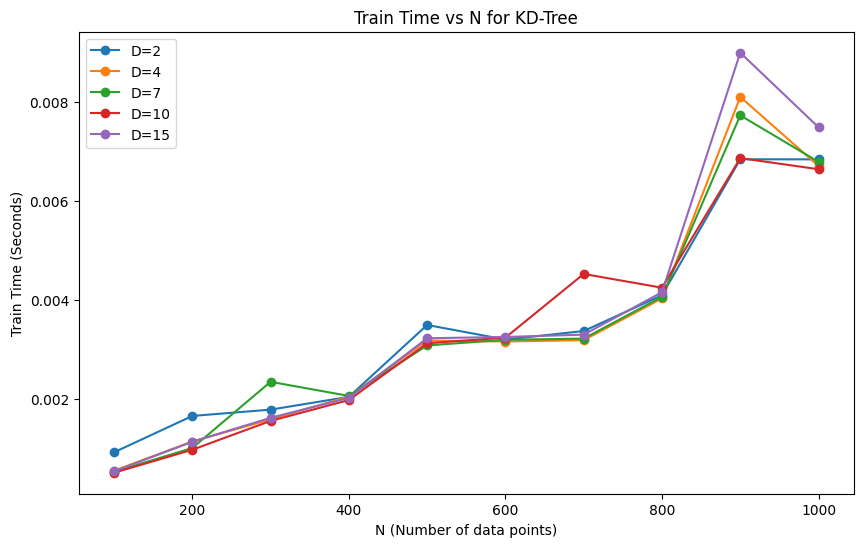

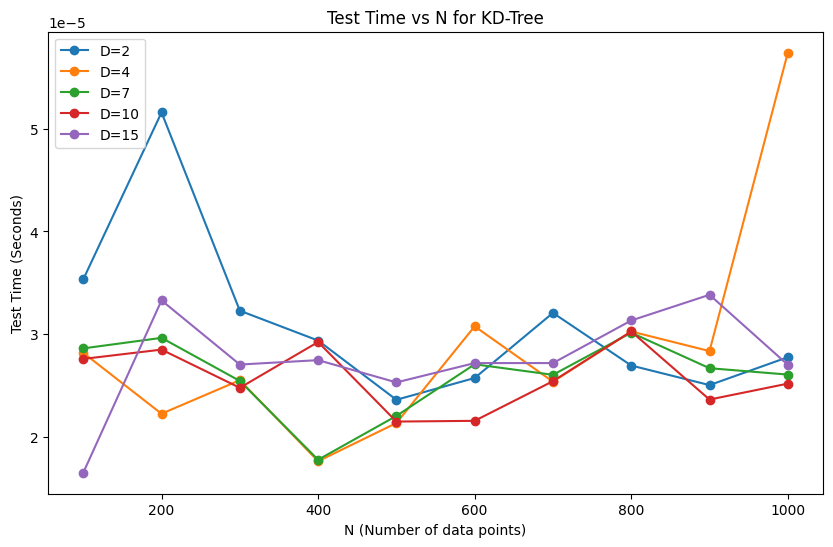

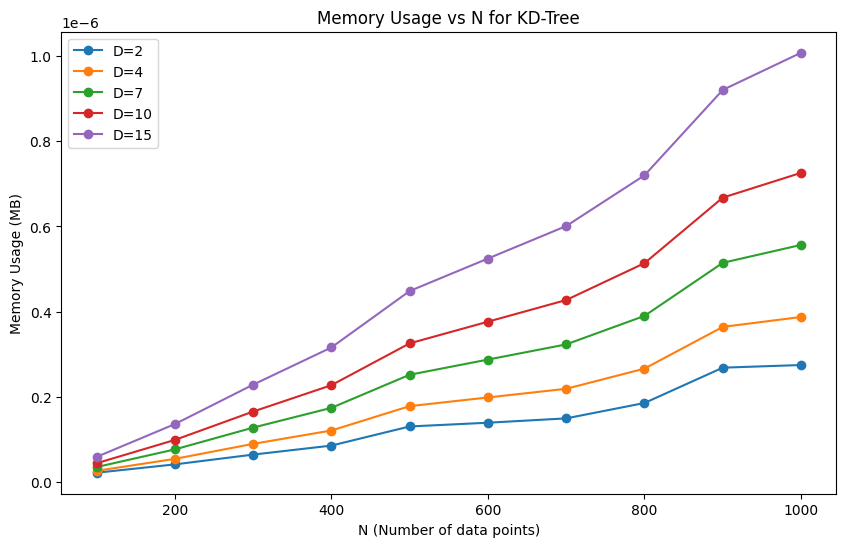

In [21]:
from sklearn.datasets import make_blobs

# Test Parameters
N_values = np.arange(100, 1001, 100)  # Different values for N (number of data points)
D_values = [2, 4, 7, 10, 15]              # Different values for D (dimension)
results = {D: {'Train Time': [], 'Test Time': [], 'Memory Usage': []} for D in D_values}

# Measure performance for each combination of N and D
for D in D_values:
    for N in N_values:
        data, _ = make_blobs(n_samples=N, centers=3, n_features=D, cluster_std=1.5, random_state=42)  # Structured data
        queries = np.random.rand(10, D)  # Generate random queries

        train_time, test_time, memory_usage = measure_performance_kdtree(data, queries, k=5)

        results[D]['Train Time'].append(train_time)
        results[D]['Test Time'].append(test_time)
        results[D]['Memory Usage'].append(memory_usage)

# Plot performance metrics
plot_performance_graph(N_values, results, 'Train Time')
plot_performance_graph(N_values, results, 'Test Time')
plot_performance_graph(N_values, results, 'Memory Usage')


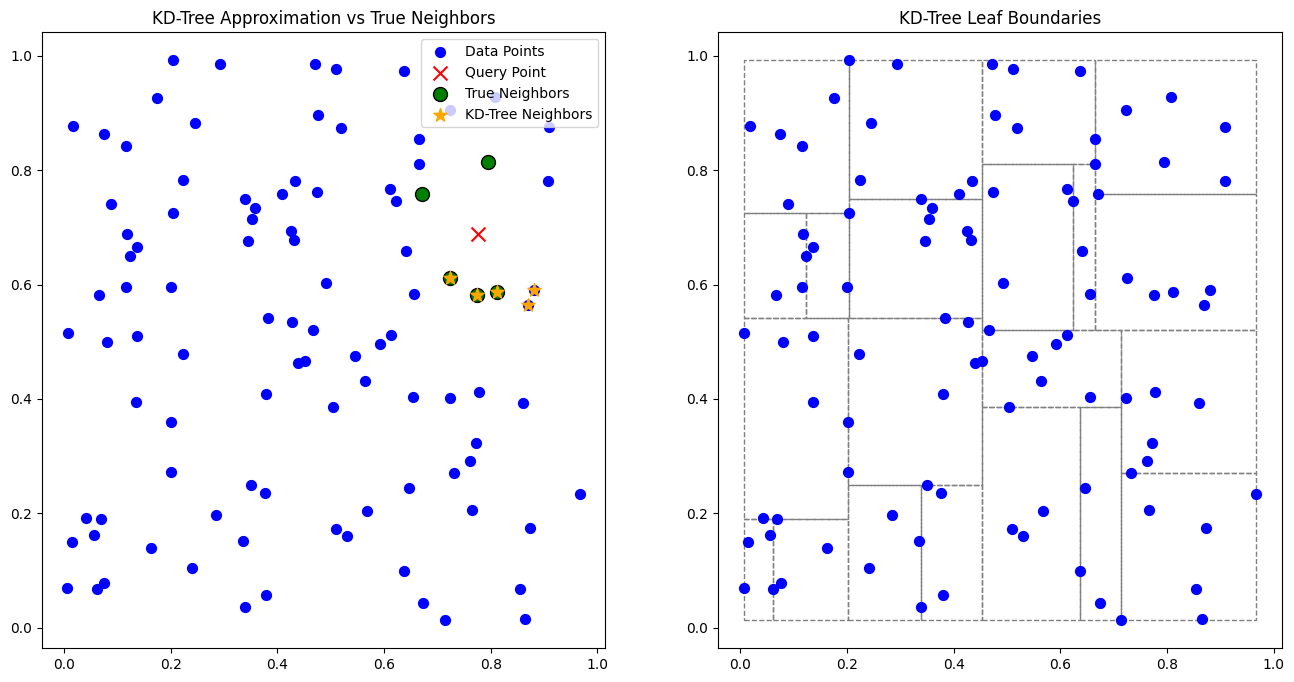

In [ ]:
# Example Usage
N = 100  # Number of points
D = 2    # Dimension of space

# Generate random data points and query point
data = np.random.rand(N, D)
query = np.random.rand(D)

# Build KD-Tree and find approximate nearest neighbors
max_leaf_size = 5  # Maximum points per leaf node
kdtree = KDTree(data, max_leaf_size=max_leaf_size)
k = 5  # Number of neighbors

# Visualize the KD-Tree splits and partitions
kdtree.visualize_tree_with_leaf_boundaries(data, query, k=k)

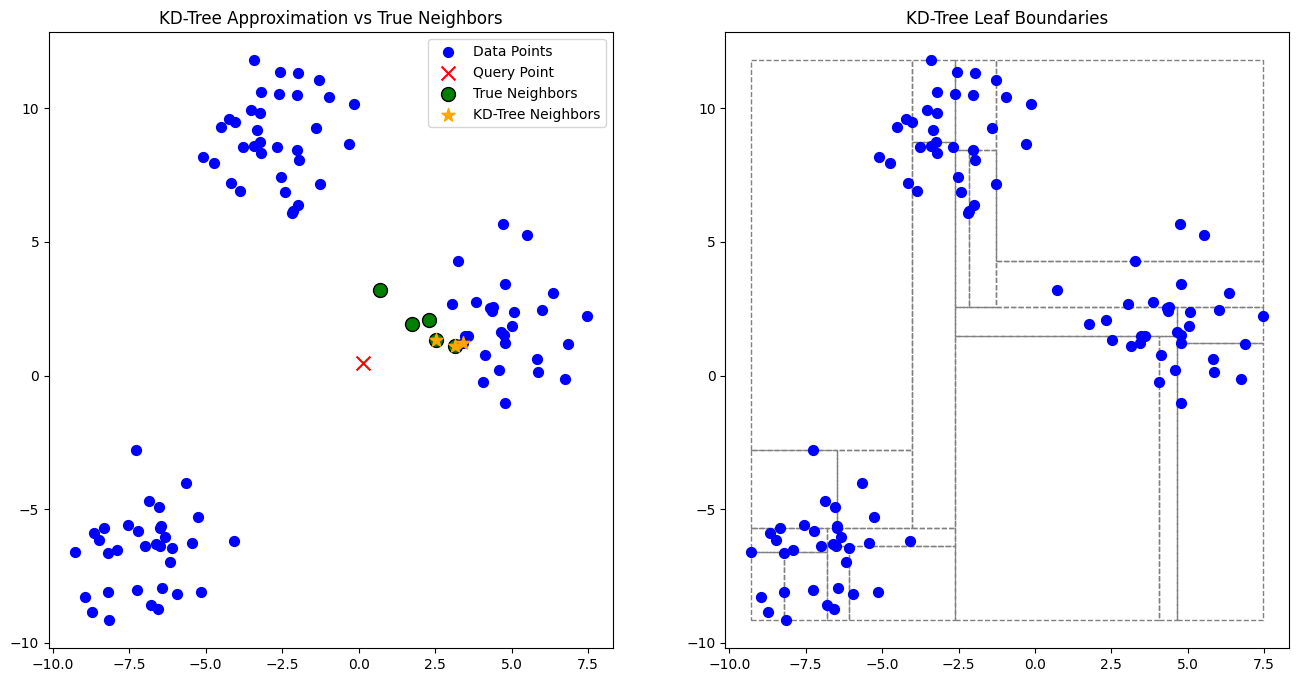

In [8]:
# Example Usage
N = 100  # Number of points
D = 2    # Dimension of space

# Generate random data points and query point
data, _ = make_blobs(n_samples=N, centers=3, n_features=D, cluster_std=1.5, random_state=42)
query = np.random.rand(D)

# Build KD-Tree and find approximate nearest neighbors
max_leaf_size = 5  # Maximum points per leaf node
kdtree = KDTree(data, max_leaf_size=max_leaf_size)
k = 5  # Number of neighbors

# Visualize the KD-Tree splits and partitions
kdtree.visualize_tree_with_leaf_boundaries(data, query, k=k)

##Varying N
1. **Training time vs N:** As N increases, the training time for building the KD-Tree generally increases. This is because more data points result in deeper trees and more recursive splits, leading to higher computational cost during the tree construction process.

2. **Query Time vs N:** The query time may slightly increase with N, but the increase is not necessarily linear. The KD-Tree can still efficiently query large datasets due to its logarithmic search time complexity in balanced trees, although the query time may vary depending on tree structure and data distribution.

3. **Memory Usage vs N:** Memory usage increases with N because more data points require more nodes to be created in the tree. Each node stores a point and references to its left and right subtrees, so as N grows, the memory required to store the tree also grows.

##Varying D
1. **Training Time vs D:** Training time remains largely unaffected by D because tree construction only requires sorting along one axis at each node.
2. **Query Time vs D:** Test time does not significantly increase with D as comparisons are made on one dimension at a time per node.
3. **Memory Usage vs D:** Memory usage increases with D because each data point stores D coordinates, requiring more space.

##Observations:

- **Naive KNN:** Best for small datasets or high-dimensional data (d>10), as it performs an exhaustive search without relying on space partitioning, making it unaffected by the curse of dimensionality.

- **KD-Tree:** Ideal for low-dimensional data (d≤10) with medium to large datasets. It efficiently partitions space using axis-aligned splits but struggles in high dimensions due to poor partitioning (curse of dimentionality --> Data points become sparse in higher dimention).

- **LSH:** Suitable for very high-dimensional data or approximate nearest neighbor searches. It hashes points into buckets, focusing on finding similar points quickly but sacrifices exactness for speed.